# Analysis-Ready, Cloud Optimized (ARCO) ERA 5 Data and _You_


<div style="display: flex; margin: 20px;">
    
  <div style="flex: 50%; padding: 5px;"> 
      <img src="https://datastore.copernicus-climate.eu/c3s/published-forms/c3sprod/reanalysis-era5-single-levels-monthly-means/overview.jpg" style="height:250px" title="ERA5 Monthly Mean U Wind Components at 100m above surface, January 2019">
  </div>
    
  <div style="flex: 50%; padding: 5px;">
      <img src="https://zarr.readthedocs.io/en/stable/_static/logo1.png" style="height:250px" title="Zarr logo">
  </div> 

</div>

Google Research & Cloud are in the process of converting a large corpus of ERA 5 data from grib into an [ARCO dataset](https://www.frontiersin.org/articles/10.3389/fclim.2021.782909/full), namely in the [Zarr format](https://zarr.readthedocs.io/). This notebook demonstrates how to access currently available datasets and make them useful. 

To hear about the current status of ERA 5 preparation, please check out [our roadmap](https://github.com/google-research/arco-era5#roadmap).

For now, let's start working with the data!

> *Pre-requisites*: Make sure you install the all notebook requirements, defined [here](https://github.com/google-research/arco-era5/tree/main/docs/environment.yml):
> ```
> conda env create -f environment.yml
> conda activate era5-docs
> ```

## Opening the Data

So far, the ERA 5 dataset has been cloud optimized; it's not fully analysis-ready yet. However, that doesn't mean that it's not immediately useful!

Let's open the Zarr data and take a look at it. We can do this with [XArray](https://xarray.pydata.org/en/stable/), once we get the right GCS permissions. We can test bucket access with [fsspec](https://filesystem-spec.readthedocs.io/en/latest/index.html):


In [1]:
import fsspec

fs = fsspec.filesystem('gs')
fs.ls('gs://arco-era5/co/')

['arco-era5/co/model-level-moisture.zarr',
 'arco-era5/co/model-level-wind.zarr',
 'arco-era5/co/single-level-forecast.zarr',
 'arco-era5/co/single-level-reanalysis.zarr']


<details>
<summary>↳Still having trouble?</summary>

Sorry about that. We're happy to troubleshoot; please file a Github issue, and we'll help with your situation.

</details>

Once you have read permissions, let's open the dataset with XArray.

In [2]:
import xarray as xr

reanalysis = xr.open_zarr(
    'gs://arco-era5/co/single-level-reanalysis.zarr', 
    chunks={'time': 48},
    consolidated=True,
)

In [3]:
print(f'size: {reanalysis.nbytes / (1024 ** 4)} TiB')

size: 27.97259556354402 TiB


In [4]:
reanalysis

<xarray.Dataset>
Dimensions:              (time: 373272, values: 542080)
Coordinates:
    depthBelowLandLayer  float64 ...
    entireAtmosphere     float64 ...
    latitude             (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude            (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    number               int64 ...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * time                 (time) datetime64[ns] 1979-01-01 ... 2021-07-31T23:0...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    d2m                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    hcc                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl1                (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl2                (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    istl3                (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    ...                   ...
    tsn                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u10                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    u100                 (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v10                  (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    v100                 (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
    z                    (time, values) float32 dask.array<chunksize=(48, 542080), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2021-12-02T05:56 GRIB to CDM+CF via cfgrib-0.9.9...
    institution:             European Centre for Medium-Range Weather Forecasts

## Understanding the Data 

The first thing you might notice are the large numbers for the Dataset dimensions. The `time` dimension is straigtforward: it represents each hour from `1979-01-01` to `2021-07-01`.

`values` is a bit more complicated. The points in this dimension correspond to a [Gaussian Grid](https://confluence.ecmwf.int/display/FCST/Gaussian+grids) representation of the data.

<center>

![N80 Original reduced Gaussian grid](https://confluence.ecmwf.int/download/thumbnails/49415103/N80_reduced.png?version=2&modificationDate=1438955091686&api=v2)

_N80 Original Reduced Gaussian Grid ([img source](https://confluence.ecmwf.int/display/FCST/Gaussian+grids))._

</center>

The  [ECMWF docs](https://confluence.ecmwf.int/display/FCST/Introducing+the+octahedral+reduced+Gaussian+grid) explain this representation at greater depth, but to quickly summarize: Gaussian grids fasciliate in more accurate computation and "compress" the dataset. Different grid representations have different tradeoffs in terms of quality of resolution at particular latitidues. 

<center>

![Comparison of the resolution variation with latitude for the reduced Gaussian grids](https://confluence.ecmwf.int/download/attachments/47300374/gaussian_grid_comparison_simple.png?version=1&modificationDate=1445596839902&api=v2)

_Comparison of the resolution variation with latitude for the reduced Gaussian grids ([img source](https://confluence.ecmwf.int/display/FCST/Introducing+the+octahedral+reduced+Gaussian+grid))._

</center>

The ERA5 reanalysis dataset is an [`N320` grid](https://confluence.ecmwf.int/display/FCST/Gaussian+grid+with+320+latitude+lines+between+pole+and+equator): This means it uses a reduced gaussian grid and samples data from 320 latitudes from each pole to the equator. But don't take my word for it! Let's inspect the attributes of the dataset to be sure. 

In [5]:
reanalysis.d2m.attrs

{'GRIB_N': 320,
 'GRIB_NV': 0,
 'GRIB_cfName': 'unknown',
 'GRIB_cfVarName': 'd2m',
 'GRIB_dataType': 'an',
 'GRIB_gridDefinitionDescription': 'Gaussian Latitude/Longitude Grid',
 'GRIB_gridType': 'reduced_gg',
 'GRIB_missingValue': 9999,
 'GRIB_name': '2 metre dewpoint temperature',
 'GRIB_numberOfPoints': 542080,
 'GRIB_paramId': 168,
 'GRIB_pl': [18,
  25,
  36,
  40,
  45,
  50,
  60,
  64,
  72,
  72,
  75,
  81,
  90,
  96,
  100,
  108,
  120,
  120,
  125,
  135,
  144,
  144,
  150,
  160,
  180,
  180,
  180,
  192,
  192,
  200,
  216,
  216,
  216,
  225,
  240,
  240,
  240,
  250,
  256,
  270,
  270,
  288,
  288,
  288,
  300,
  300,
  320,
  320,
  320,
  324,
  360,
  360,
  360,
  360,
  360,
  360,
  375,
  375,
  384,
  384,
  400,
  400,
  405,
  432,
  432,
  432,
  432,
  450,
  450,
  450,
  480,
  480,
  480,
  480,
  480,
  486,
  500,
  500,
  500,
  512,
  512,
  540,
  540,
  540,
  540,
  540,
  576,
  576,
  576,
  576,
  576,
  576,
  600,
  600,
  600,

Notice the key:value pairs `'GRIB_N': 320`, `'GRIB_gridDefinitionDescription': 'Gaussian Latitude/Longitude Grid'` and `'GRIB_gridType': 'reduced_gg'`. These all confirm that we are in fact dealing with a `N320` reduced gaussian grid. 

You may have noticed the large numpy array at the `'GRIB_pl'` attribute. What do these numbers mean? 

These represents the number of longitude points for every latitude. The array is size 620 – it covers 320 latitudes from the equator to the poles for both hemisphers. 

Let's quickly check to see if this metadata adds up to the number of values. 

In [6]:
print(reanalysis.d2m.shape)
print(sum(reanalysis.d2m.attrs['GRIB_pl']))

(373272, 542080)
542080


Great! It checks out. This attribute may prove useful in the future if one wanted to create a specialized manipulations of the data. 

* * * 

In printing the attributes, you also may have noticed some useful information about the variable `d2m`. Of note, the data variable attribute includes the `GRIB_name`, `longName`, and `units`, which help describe the data. If you ever want to find out _more_ about a data variable, you can always look up the paramter in ECMWF's parameter DB: 

https://apps.ecmwf.int/codes/grib/param-db

> Recommended: use the `'GRIB_paramId'` or `'GRIB_shortName'` attribute for disambugous lookup. In this example, you would search "2d" or "168".

## Slicing and Indexing Spectral Data

We can slice the data across time using [standard XArray methods](https://xarray.pydata.org/en/stable/user-guide/indexing.html). For example:

In [7]:
recent_an = reanalysis.sel(time=slice('2020-01-01', '2021-01-01'))

geopotential_t0 = recent_an.z[0, :]
most_recent_ds = recent_an.isel(time=-1)
new_years_ds = recent_an.sel(time='2020-01-01')

Slicing by location is a bit trickier, due to the gaussian grid.

The best way to slice by area is to mask the Dataset by the desired coordinate lat/lng.

> Note: The [coordinate system for ERA 5](https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference#ERA5:Whatisthespatialreference-Coordinatesystem) is [-90, +90] for latitude and [0, 360] for longitude with respect for the Greenwich Prime Meridian (i.e. different from normal [-180, 180]). You may decide it makes sense to [assing new coordiantes](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html) to work with what you're familiar with.


In [8]:
def lon_to_360(dlon: float) -> float:
  return ((360 + (dlon % 360)) % 360)

US_ds = recent_an.where(
    (recent_an.longitude > lon_to_360(-171.79)) & (recent_an.latitude > 18.91) &
    (recent_an.longitude < lon_to_360(-66.96)) & (recent_an.latitude < 71.35),
    drop=True
)
US_ds

/Users/alxrsngrtn/homebrew/Caskroom/miniconda/base/envs/era5-docs1/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset>
Dimensions:              (time: 8808, values: 49625)
Coordinates:
    depthBelowLandLayer  float64 100.0
    entireAtmosphere     float64 0.0
    latitude             (values) float64 dask.array<chunksize=(49625,), meta=np.ndarray>
    longitude            (values) float64 dask.array<chunksize=(49625,), meta=np.ndarray>
    number               int64 0
    step                 timedelta64[ns] 00:00:00
    surface              float64 0.0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2021-01-01T23:0...
    valid_time           (time) datetime64[ns] dask.array<chunksize=(24,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables: (12/38)
    cape                 (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    d2m                  (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    hcc                  (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    istl1                (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    istl2                (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    istl3                (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    ...                   ...
    tsn                  (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    u10                  (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    u100                 (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    v10                  (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    v100                 (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
    z                    (time, values) float32 dask.array<chunksize=(24, 49625), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2021-12-02T05:56 GRIB to CDM+CF via cfgrib-0.9.9...
    institution:             European Centre for Medium-Range Weather Forecasts

## Plotting the original grid

The best way to visualize the data in the original grid is to use Matplotlib's `scatter` method over a `cartopy` projection.

Notice the effect of the gaussian representation on the plot.
> Warning: Displaying these plots will be slow. 

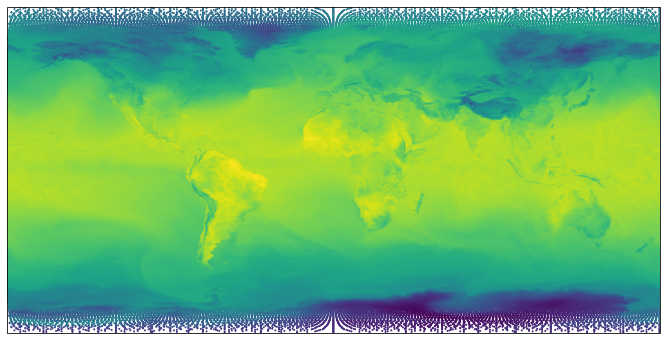

In [9]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(12, 6))
plt.axes(projection=ccrs.PlateCarree())
plt.scatter(
    recent_an.longitude,
    recent_an.latitude,
    c=recent_an.t2m.sel(time='2020-10-31T18').values,
    s=1
)

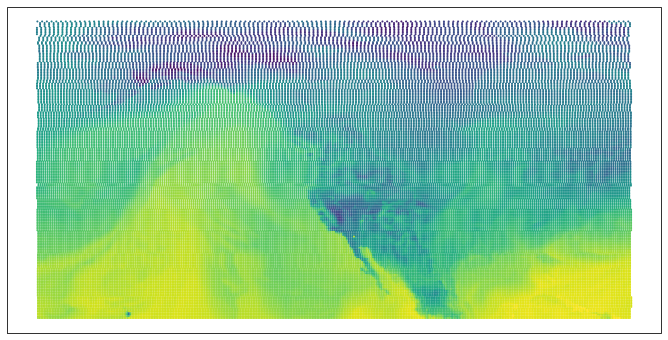

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

plt.figure(figsize=(12, 6))
plt.axes(projection=ccrs.PlateCarree())
plt.scatter(
    US_ds.longitude,
    US_ds.latitude,
    c=US_ds.d2m.sel(time='2020-10-31T18').values,
    s=1,
)

## Regridding

_credit: [shoyer@](https://github.com/shoyer)_

From the gaussian representation, we have many choices to regrid and interpolate the data. In this example, we will regrid with linear interpolation on a triangular mesh using `scipy.spatial.Delaunay` ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html)).



In [11]:
import xarray as xr
import scipy.spatial
import numpy as np

def mirror_point_at_360(ds):
  extra_point = (
      ds.where(ds.longitude == 0, drop=True)
      .assign_coords(longitude=lambda x: x.longitude + 360)
  )
  return xr.concat([ds, extra_point], dim='values')

def build_triangulation(x, y):
  grid = np.stack([x, y], axis=1)
  return scipy.spatial.Delaunay(grid)

def interpolate(data, tri, mesh):
  indices = tri.find_simplex(mesh)
  ndim = tri.transform.shape[-1]
  T_inv = tri.transform[indices, :ndim, :]
  r = tri.transform[indices, ndim, :]
  c = np.einsum('...ij,...j', T_inv, mesh - r)
  c = np.concatenate([c, 1 - c.sum(axis=-1, keepdims=True)], axis=-1)
  result = np.einsum('...i,...i', data[:, tri.simplices[indices]], c)
  return np.where(indices == -1, np.nan, result)

In [12]:
%time ds_feb20 = reanalysis.sel(time=slice('2020-02-01', '2020-02-28')).pipe(mirror_point_at_360)

CPU times: user 294 ms, sys: 31.5 ms, total: 325 ms
Wall time: 3.87 s


In [13]:
%time tri = build_triangulation(ds_feb20.longitude, ds_feb20.latitude)

CPU times: user 7.31 s, sys: 586 ms, total: 7.9 s
Wall time: 8.87 s


### Visualizing the mesh

We're using a naive 2D mesh in latitude/longitude mesh, which results in a strange triangulation near the poles. A better approach would be to use a [stereographic projection](https://www.redblobgames.com/x/1842-delaunay-voronoi-sphere/).

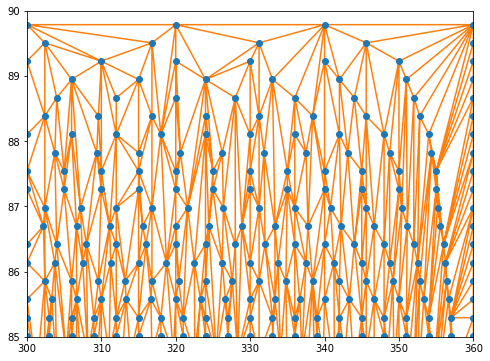

In [14]:
# near the north pole
scipy.spatial.delaunay_plot_2d(tri);
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.xlim(300, 360)
_ = plt.ylim(85, 90)

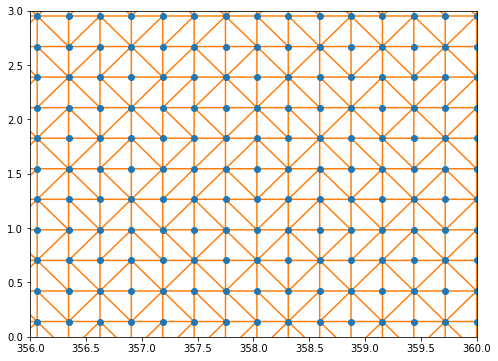

In [15]:
# near the equator
scipy.spatial.delaunay_plot_2d(tri);
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.xlim(356, 360)
_ = plt.ylim(0, 3)

### Regrid fields

1/4 of a degree is approximately native resolution for ERA5.

In [16]:
longitude = np.linspace(0, 360, num=360*4+1)
latitude = np.linspace(-90, 90, num=180*4+1)
mesh = np.stack(np.meshgrid(longitude, latitude, indexing='ij'), axis=-1)
%time d2m_mesh = interpolate(ds_feb20.d2m.values, tri, mesh)
d2m_feb20 = xr.DataArray(d2m_mesh, coords=[('time', ds_feb20.time.data), ('longitude', longitude), ('latitude', latitude)])

CPU times: user 1min 16s, sys: 51 s, total: 2min 7s
Wall time: 5min 37s


Now that the data has been regridded, we can index and plot with standard XArray operations...

> Notice that plotting is faster.

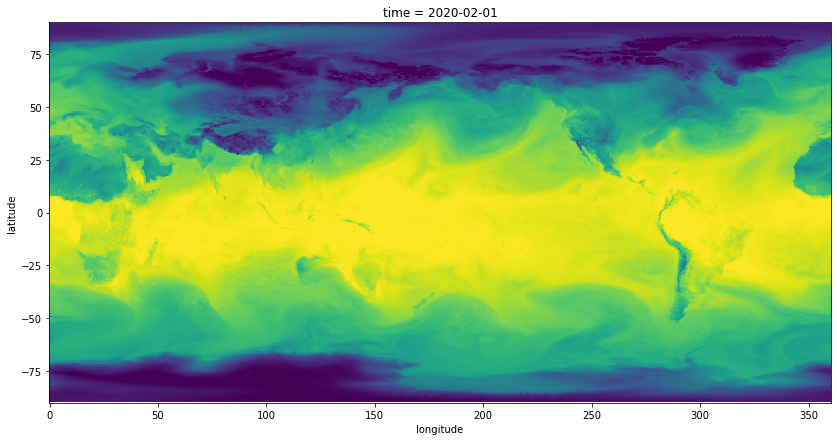

In [17]:
d2m_feb20[0].plot(x='longitude', y='latitude', cmap='viridis', size=7, aspect=2, add_colorbar=False, robust=True)

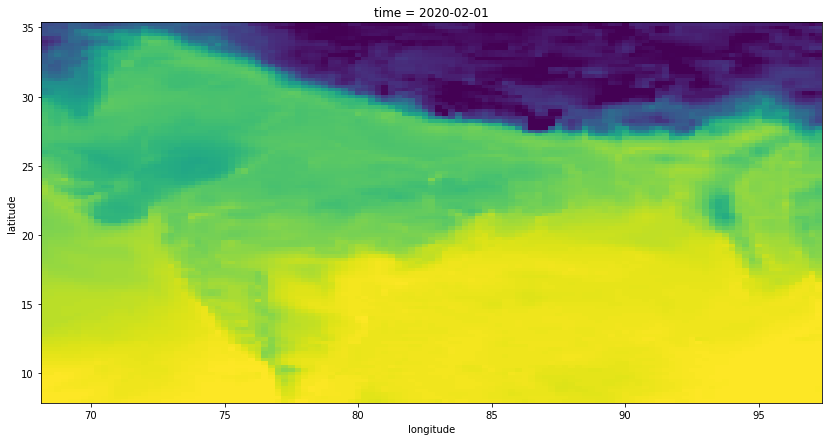

In [18]:
# Zoom into India... 
# W: 68.1766451354, S: 7.96553477623, E: 97.4025614766, N: 35.4940095078
(
    d2m_feb20
    .sel(latitude=slice(7.965, 35.494), longitude=slice(lon_to_360(68.176), lon_to_360(97.402)))
    .isel(time=0)
    .plot(x='longitude', y='latitude', cmap='viridis', size=7, aspect=2, add_colorbar=False, robust=True)
)

## Preview: Other cloud-optimized datasets

Beyond the surface level reanalysis, we've also made a few other datasets available. You can see previews of each of these in the next section. Stay tuned – we're actively developing demo notebooks.

### Surface forecasts

In [19]:
import xarray as xr

forecasts = xr.open_zarr(
    'gs://arco-era5/co/single-level-forecast.zarr/', 
    chunks={'time': 48},
    consolidated=True,
)

In [20]:
print(f'size: {forecasts.nbytes / (1024 ** 4)} TiB')

size: 24.47602165160788 TiB


In [21]:
forecasts

<xarray.Dataset>
Dimensions:     (time: 31106, step: 19, values: 542080)
Coordinates:
    latitude    (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    number      int64 ...
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 17:00:00 18:00:00
    surface     float64 ...
    valid_time  (time, step) datetime64[ns] dask.array<chunksize=(48, 19), meta=np.ndarray>
Dimensions without coordinates: time, values
Data variables: (12/21)
    cp          (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    crr         (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    csf         (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    csfr        (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    es          (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    gwd         (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    ...          ...
    smlt        (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    ssrd        (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    str         (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    strd        (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    tp          (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
    ttr         (time, step, values) float32 dask.array<chunksize=(48, 19, 542080), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2022-04-29T19:15 GRIB to CDM+CF via cfgrib-0.9.9...
    institution:             European Centre for Medium-Range Weather Forecasts

### Atmospheric data: Model level data


In [22]:
import xarray as xr

ml_moisture = xr.open_zarr(
    'gs://arco-era5/co/model-level-moisture.zarr', 
    chunks={'time': 48},
    consolidated=True,
)

In [23]:
print(f'{ml_moisture.nbytes / (1024 ** 4)} TiB')

704.5779759364232 TiB


In [24]:
ml_moisture

<xarray.Dataset>
Dimensions:     (time: 372552, hybrid: 137, values: 542080)
Coordinates:
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
    latitude    (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    step        timedelta64[ns] ...
  * time        (time) datetime64[ns] 1979-01-01 ... 2021-07-01T23:00:00
    valid_time  (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    cc          (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    ciwc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    clwc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    crwc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    cswc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    o3          (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    q           (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2022-03-28T12:02 GRIB to CDM+CF via cfgrib-0.9.9...
    institution:             European Centre for Medium-Range Weather Forecasts

In [25]:
import xarray as xr

ml_wind = xr.open_zarr(
    'gs://arco-era5/co/model-level-wind.zarr', 
    chunks={'time': 48},
    consolidated=True,
)

In [26]:
print(f'{ml_wind.nbytes / (1024 ** 4)} TiB')

304.6952120509377 TiB


In [27]:
ml_wind

<xarray.Dataset>
Dimensions:     (time: 372552, hybrid: 137, values: 410240)
Coordinates:
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
    step        timedelta64[ns] ...
    valid_time  (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: time, values
Data variables:
    d           (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 410240), meta=np.ndarray>
    t           (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 410240), meta=np.ndarray>
    vo          (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 410240), meta=np.ndarray>
    w           (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 410240), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2022-02-11T02:12 GRIB to CDM+CF via cfgrib-0.9.9...
    institution:             European Centre for Medium-Range Weather Forecasts

In [28]:
ml_moisture

<xarray.Dataset>
Dimensions:     (time: 372552, hybrid: 137, values: 542080)
Coordinates:
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
    latitude    (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude   (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    step        timedelta64[ns] ...
  * time        (time) datetime64[ns] 1979-01-01 ... 2021-07-01T23:00:00
    valid_time  (time) datetime64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    cc          (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    ciwc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    clwc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    crwc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    cswc        (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    o3          (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
    q           (time, hybrid, values) float32 dask.array<chunksize=(48, 137, 542080), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2022-03-28T12:02 GRIB to CDM+CF via cfgrib-0.9.9...
    institution:             European Centre for Medium-Range Weather Forecasts

## Looking ahead... 

These cloud-optimized datasets are much easier to work with than raw grib data. The unprocessed spectral representation yields full control over projection and interpolation details to the user. We expect that this version of the data will be helpful for many research use cases. 

At the same time, we anticipate that many users will want common preprocessing applied. In the next phase of development, the our team in Research will work towards curating this corpus into an "Analysis Ready" version. Here, we will make practical, opinionalted choices towards making ERA 5 accessible and useful. 

Stay tunes to [our roadmap](https://github.com/google-research/arco-era5#roadmap) to follow this development.  Or, if you have a feedback over how the data should be structured, please say so in a Github issue.

Thanks for following this notebook!